These sources were of particular help:

https://medium.com/internet-of-technology/segmentation-with-yolov8-44147312498e

https://github.com/azureology/kitti-velo2cam/blob/master/proj_velo2cam.py



In [ ]:
!pip install ultralytics opencv-python

In [2]:
!git clone https://github.com/azureology/kitti-velo2cam.git

Cloning into 'kitti-velo2cam'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 30 (delta 8), reused 24 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 2.65 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
!git clone https://github.com/evanwporter/kitti.git

Cloning into 'kitti'...
remote: Enumerating objects: 1578, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1578 (delta 0), reused 2 (delta 0), pack-reused 1575 (from 2)
Receiving objects: 100% (1578/1578), 799.67 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (1548/1548), done.


KITTI has 4 cameras per frame:

* `image_0` → Grayscale left
* `image_1` → Grayscale right
* `image_2` → Color left
* `image_3` → Color right

In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

from shapely.geometry import Point, Polygon

from ultralytics import YOLO
import cv2

from google.colab.patches import cv2_imshow

In [5]:
path = "kitti/person"

name = "0000000001"

image = f"{path}/image_02/data/{name}.png"

velo = f"{path}/velodyne_points/data"

bin = f"{velo}/{name}.bin"

calibration = f"{path}/calibration"

In [59]:
def read_raw_calib_file(file_path):
    calib = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ':' not in line:
                continue  # skip lines without key-value pairs

            key, value = line.strip().split(':', 1)
            value = value.strip()
            if not value:
                continue  # skip empty entries

            # Convert to float array
            val_split = value.split()
            try:
                float_vals = [float(v) for v in val_split]
                # Guess shape based on key
                if key.startswith('R_') or key.startswith('K_') or key.startswith('R_rect_'):
                    calib[key] = np.array(float_vals).reshape(3, 3)
                elif key.startswith('P_rect_'):
                    calib[key] = np.array(float_vals).reshape(3, 4)
                elif key.startswith('T_'):
                    calib[key] = np.array(float_vals).reshape(3,)
                elif key.startswith('D_'):
                    calib[key] = np.array(float_vals)  # distortion coefficients
                elif key.startswith('S_') or key.startswith('S_rect_'):
                    calib[key] = np.array(float_vals).astype(int)  # image size
                else:
                    calib[key] = np.array(float_vals)
            except ValueError:
                # Non-numeric values, ignore or store raw
                calib[key] = value
    return calib


In [60]:
calib = read_raw_calib_file(f'{calibration}/calib_cam_to_cam.txt')

P2 = calib['P_rect_02']     # Projection matrix (3x4)
R2 = calib['R_rect_02']     # Rectification (3x3)
T2 = calib['T_02']          # Translation from cam0 to cam2

You're building a homogeneous transformation matrix:

$$
\text{Tr}_{\text{velo→cam}} =
\begin{bmatrix}
R & T \\
0 & 1 \\
\end{bmatrix}
$$

Where:

* `R` is a 3×3 rotation matrix
* `T` is a 3×1 translation vector
* The bottom row `[0, 0, 0, 1]` makes it a 4×4 affine transform matrix

In [61]:
velo_calib = read_raw_calib_file(f'{calibration}/calib_velo_to_cam.txt')
R = velo_calib["R"].reshape((3, 3))
T = velo_calib["T"].reshape((3, 1))

In [62]:
Tr_velo_to_cam = np.eye(4)
Tr_velo_to_cam[:3, :3] = R
Tr_velo_to_cam[:3, 3] = T.flatten()

In [66]:
Tr_velo_to_cam

array([[   0.006928,    -0.99997,  -0.0027578,   -0.024577],
       [  -0.001163,   0.0027498,          -1,   -0.061272],
       [    0.99998,   0.0069311,  -0.0011439,     -0.3321],
       [          0,           0,           0,           1]])

In [67]:
# P2 (3 x 4) for left eye
P2 = calib['P_rect_02']

# Rectification (3x3)
R2_rect = np.eye(4)
R2_rect[:3, :3] = calib['R_rect_02']

The Velodyne data looks like $[x, y, z, \text{intensity}]^T$

* $x$: Forward direction (in meters)
* $y$: Left direction (in meters)
* $z$: Up direction (in meters)
*	$\text{intensity}$: Reflectance

In [102]:
# Read Velodyne
# read raw data from binary
# the data is stored as (N, 4) (but flattened)
scan = np.fromfile(bin, dtype=np.float32).reshape((-1, 4))  # (N,  4)

# remove points behind vehicle
# since the LiDAR is 360 around the vehicle
scan = scan[scan[:, 0] > 0]

# lidar xyz (front, left, up)
# relative to lidar's frame
lidar_xyz = np.vstack((scan[:, :3].T, np.ones((1, scan.shape[0])))) # (3, N)

# points_xyz is the (front, left, up) relative to the camera's frame
points_xyz = R2_rect @ Tr_velo_to_cam @ lidar_xyz # (4, N)

In [103]:
# Project to image
# this is the lidar but coverted to the pixels of the camera
cam_coords = P2 @ points_xyz
points_uvw = cam_coords.copy();
points_uvw[:2] /= points_uvw[2]

# u, v w are numpy arrays of shape (N,)
u, v, w = points_uvw[0], points_uvw[1], points_uvw[2]

In [104]:
points_uvw

array([[     603.86,      601.63,      597.93, ...,      910.87,      907.77,       904.9],
       [     144.51,      144.58,      151.81, ...,      523.01,       522.8,      522.27],
       [     17.996,      18.012,      50.924, ...,      3.3854,      3.4185,      3.4445]])

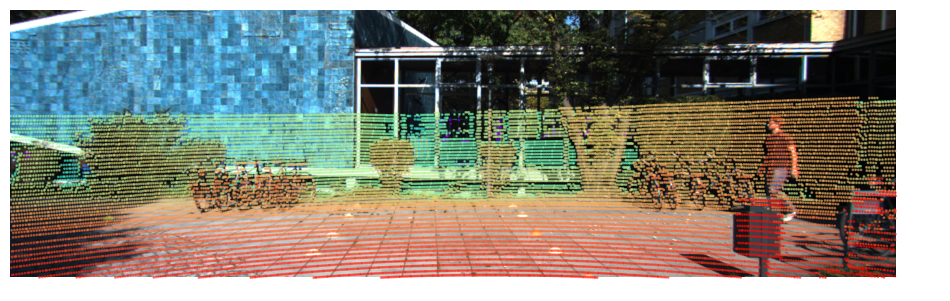

In [105]:
img = mpimg.imread(image)
IMG_H, IMG_W, _ = img.shape

plt.figure(figsize=(12, 6))
plt.imshow(img)
mask = (u >= 0) & (u < IMG_W) & (v >= 0) & (v < IMG_H) & (w > 0)
plt.scatter(u[mask], v[mask], c=w[mask], cmap='rainbow_r', s=1, alpha=0.5, vmin=5, vmax=30)
plt.axis('off')
plt.show()


image 1/1 /content/kitti/person/image_02/data/0000000001.png: 224x640 1 person, 9 bicycles, 1793.2ms
Speed: 2.2ms preprocess, 1793.2ms inference, 15.9ms postprocess per image at shape (1, 3, 224, 640)


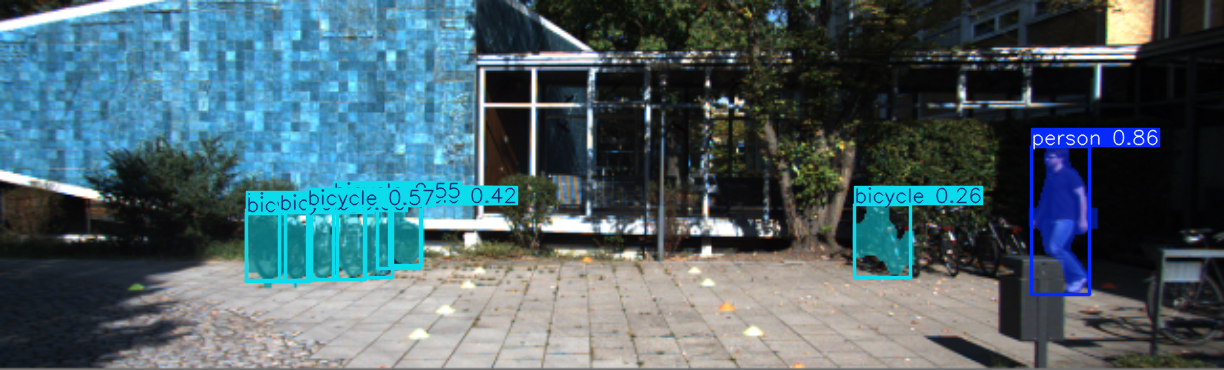

In [72]:
# Load segmentation model
model = YOLO('yolov8x-seg.pt')  # or yolov8n-seg.pt for faster inference

# Inference on image
results = model(image)  # replace with your image path

# Results is just the list of images
result = results[0]

# Visualize
result.show()

10


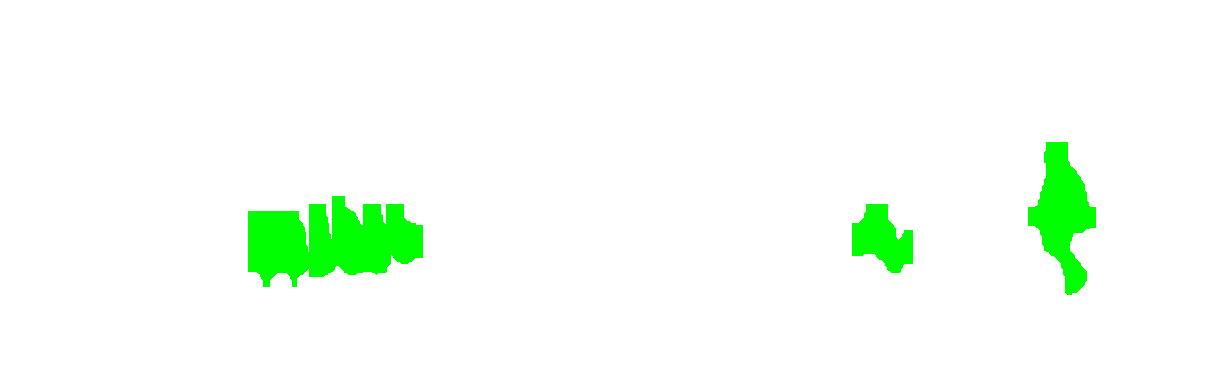

In [74]:
# Get the height and width of the original image
height, width = result.orig_shape

# Create the background
background = np.ones((height, width, 3), dtype=np.uint8) * 255

# Get all predicted masks
masks = result.masks.xy

print(len(masks))

i = 0
for mask in masks:
    # if (i == 0):
    # For each mask fill the contours
    mask = mask.astype(int)
    cv2.drawContours(background, [mask], -1, (0, 255, 0), thickness=cv2.FILLED)
    i += 1

# Display the result
cv2_imshow(background)
cv2.waitKey(0)
cv2.destroyAllWindows()

So we now want to overlay to view the Lidar of specific objects.

To do so we use shapely Polygons to represent the mask, then for each point in the LIDAR we check if the polygon contains that point.

In [106]:
def filter_pts(mask_index):
  poly_coords = result.masks.xy[mask_index]  # shape (N, 2), in (x, y) == (u, v)

  # Create a Shapely polygon
  polygon = Polygon(poly_coords)

  # Convert u,v to shapely Points
  inside_mask = [polygon.contains(Point(u_, v_)) for u_, v_, _ in points_uvw.T]

  # Filter the uvz points
  filtered_uvw = points_uvw.T[inside_mask]

  filtered_xyz = points_xyz.T[inside_mask]

  dists = np.linalg.norm(filtered_xyz, axis=1)  # shape: (M,)

  return filtered_uvw, dists

The maximum distance is definitely a little wonky. This is likely due to the inclusion of background pixels within the mask.

Mask 0: person
Mean distance to object: 11.33 meters
Min: 6.37, Max: 21.19

Mask 1: bicycle
Mean distance to object: 13.21 meters
Min: 10.86, Max: 20.36

Mask 2: bicycle
Mean distance to object: 13.11 meters
Min: 10.58, Max: 20.22

Mask 3: bicycle
Mean distance to object: 13.89 meters
Min: 11.20, Max: 18.41

Mask 4: bicycle
Mean distance to object: 12.92 meters
Min: 10.57, Max: 16.28

Mask 5: bicycle
Mean distance to object: 12.72 meters
Min: 10.86, Max: 20.48

Mask 6: bicycle
Mean distance to object: 13.71 meters
Min: 11.02, Max: 18.41

Mask 7: bicycle
Mean distance to object: 13.22 meters
Min: 11.12, Max: 17.39

Mask 8: bicycle
Mean distance to object: 13.04 meters
Min: 11.02, Max: 17.39

Mask 9: bicycle
Mean distance to object: 12.58 meters
Min: 10.54, Max: 18.93



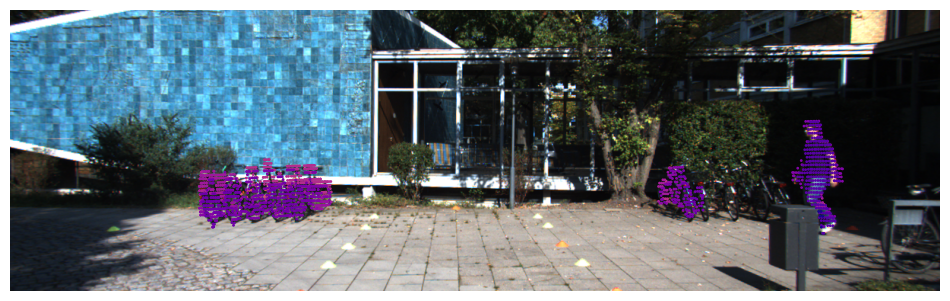

In [107]:
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')

for i in range(len(result)):
  cls_id = int(result[i].boxes.cls)
  class_name = result.names[cls_id]
  print(f"Mask {i}: {class_name}")

  filtered_points, dists = filter_pts(i)
  plt.scatter(filtered_points[:, 0], filtered_points[:, 1],
            c=filtered_points[:, 2], cmap='plasma', s=1,
             vmin=5, vmax=30)

  print(f"Mean distance to object: {np.mean(dists):.2f} meters")
  print(f"Min: {np.min(dists):.2f}, Max: {np.max(dists):.2f}")
  print()

plt.show()